<a href="https://colab.research.google.com/github/kangel429/DeepLearning/blob/master/Lesson7_resnet_mnist_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Deep Learning for Coders, v3

# Lesson7_resnet_mnist

# MNIST CNN

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

### Data 数据

In [0]:
path = untar_data(URLs.MNIST)         #MNIST 데이터 셋 다운

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/testing'),
 PosixPath('/root/.fastai/data/mnist_png/training')]

In [0]:
il = ImageList.from_folder(path, convert_mode='L') #이미지 리스트   이 이미지는  convert_mode='L' 흑백모드

In [0]:
il.items[0]       #이 이미지의 아이템은 -- 33125.png

PosixPath('/root/.fastai/data/mnist_png/testing/0/3710.png')

In [0]:
defaults.cmap='binary'

In [0]:
il               #실제 이미지의 객체

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png

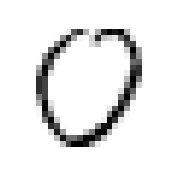

In [0]:
il[0].show()      #실제 이미지의 객체를 보여주기

In [0]:
sd = il.split_by_folder(train='training', valid='testing')#훈련 데이터와 검증 데이터 폴더를 나누고

In [0]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
(path/'training').ls()          #훈련폴더 안에 있는 이미지

[PosixPath('/root/.fastai/data/mnist_png/training/0'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/4'),
 PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/3'),
 PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/2'),
 PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/9')]

In [0]:
ll = sd.label_from_folder()           #라벨링 하기

In [0]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
x,y = ll.train[0]             #첫번째 있는 데이터 가지고 오기

0 torch.Size([1, 28, 28])


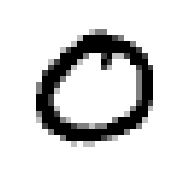

In [0]:
x.show()
print(y,x.shape)              #첫번째 있는 데이터 찍어보기

In [0]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], []) #무작위의 패딩

In [0]:
ll = ll.transform(tfms)       #변형

In [0]:
bs = 128

In [0]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [0]:
x,y = data.train_ds[0]    #노멀라이징 해서 다시 첫번째 있는 데이터 가지고 오기

0


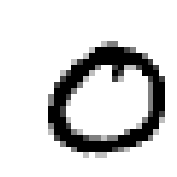

In [0]:
x.show()
print(y)

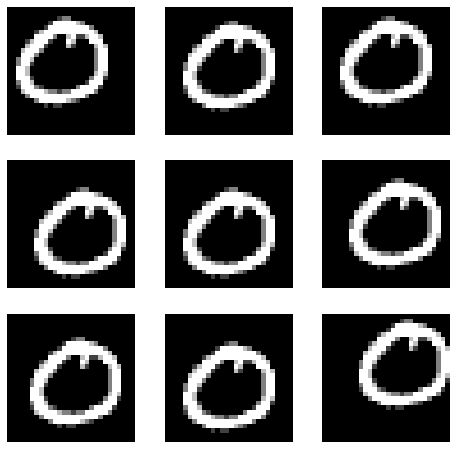

In [0]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')  #무작위 패딩을 했기 때문에 각각의 0이 다른 위치에 있다
plot_multi(_plot, 3, 3, figsize=(8,8))              #그림을 멀티로 보여줌 3*3

In [0]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

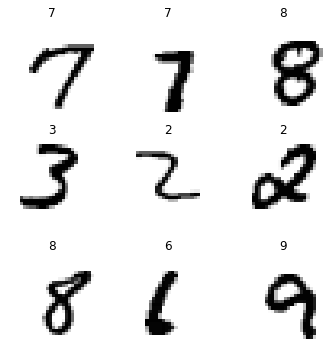

In [0]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm 批量正规化（归一化）的基础版CNN模型

In [0]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1) # 커널 크기 3 보폭 2 패딩 1  컨볼 루션이있을 때마다 한 픽셀 매번 두 단계 씩 점프합니다. 그리드 크기를 반으로 줄입니다.

In [0]:
model = nn.Sequential(
    conv(1, 8), # 14    conv함수를 이용해서 반복 작업해줌
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)     #모델 만듬

In [0]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [0]:
xb = xb.cuda()    #GPU에 팝업 xb.cuda()하고 배치를 모델에 전달

In [0]:
model(xb).shape

torch.Size([128, 10])

In [0]:
learn.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


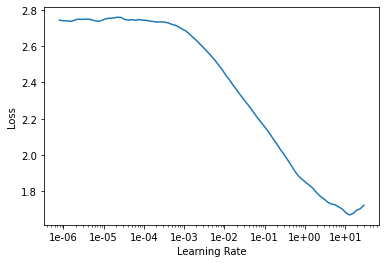

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.206528,0.210178,0.930300,00:25
1,0.123284,0.077075,0.974400,00:25
2,0.066209,0.040364,0.988000,00:25


### Refactor 重构

In [0]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2) #전환, 배치 규범, ReLU의 조합

In [0]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [0]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.222367,0.134600,0.960400,00:24
1,0.186605,0.131939,0.959200,00:25
2,0.173815,0.137958,0.955800,00:25
3,0.147280,0.080275,0.975400,00:24
4,0.118813,0.103361,0.968000,00:25
5,0.110214,0.066836,0.978400,00:24
6,0.092770,0.077580,0.975300,00:25
7,0.065802,0.039755,0.987400,00:25
8,0.050196,0.029891,0.989400,00:25
9,0.047182,0.028321,0.990300,00:25


**굵은 텍스트**### Resnet-ish
깊은 네트워크 높은 훈련과 테스트 오류 --> 그래서 등장

In [0]:
class ResBlock(nn.Module):      #nn 모듈의 인자값을 집어넣을 수 있는 객체 만들기  ---- 이 함수를 통해서 좀 더 정확한 결과물을 얻을 수 있다
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)  #레이어 2개 만듬
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [0]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [0]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [0]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [0]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


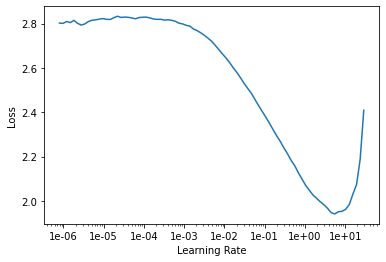

In [0]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.217230,0.171914,0.950300,00:28
1,0.131277,0.137905,0.956400,00:28
2,0.115509,0.390081,0.883600,00:28
3,0.074846,0.095786,0.971200,00:28
4,0.068126,0.074131,0.976400,00:28
5,0.060369,0.072095,0.979300,00:28
6,0.049620,0.036928,0.988000,00:28
7,0.043634,0.033345,0.990000,00:28
8,0.033433,0.023368,0.992800,00:28
9,0.024183,0.018928,0.994300,00:28


In [0]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________